In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import os
import re
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import ScalarFormatter
from sklearn.metrics import r2_score
from tqdm import tqdm

from panda.utils import (
    apply_custom_style,
)

/stor/work/AMDG_Gilpin_Summer2024/miniconda3/envs/dystformer/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
apply_custom_style("../config/plotting.yaml")

In [4]:
DEFAULT_COLORS = plt.rcParams["axes.prop_cycle"].by_key()["color"]

In [5]:
WORK_DIR = os.getenv("WORK", "")
DATA_DIR = os.path.join(WORK_DIR, "data")

In [6]:
def get_sorted_metric_fnames(save_dir):
    fnames = [
        f
        for f in os.listdir(save_dir)
        if f.endswith(".json") and "distributional_metrics" and "lyap" in f
    ]

    def extract_window(fname):
        m = re.search(r"window-(\d+)", fname)
        return int(m.group(1)) if m else float("inf")

    return sorted(fnames, key=extract_window)


# panda_metrics_save_dir = (
#     f"{WORK_DIR}/eval_results/panda/pft_chattn_emb_w_poly-0/test_zeroshot/metrics_run1"
# )
# # NOTE: we also have for chronos_nondeterministic, replace "chronos" with "chronos_nondeterministic" in the paths below
# chronos_sft_metrics_save_dir = (
#     f"{WORK_DIR}/eval_results/chronos/chronos_t5_mini_ft-0/test_zeroshot/metrics_run1"
# )
# chronos_zs_metrics_save_dir = (
#     f"{WORK_DIR}/eval_results/chronos/chronos_mini_zeroshot/test_zeroshot/metrics_run1"
# )

panda_metrics_save_dir = (
    f"{WORK_DIR}/eval_results/panda/pft_chattn_emb_w_poly-0/test_zeroshot"
)
# NOTE: we also have for chronos_nondeterministic, replace "chronos" with "chronos_nondeterministic" in the paths below
chronos_sft_metrics_save_dir = f"{WORK_DIR}/eval_results/chronos_nondeterministic/chronos_t5_mini_ft-0/test_zeroshot"
chronos_zs_metrics_save_dir = f"{WORK_DIR}/eval_results/chronos_nondeterministic/chronos_mini_zeroshot/test_zeroshot"


panda_metrics_fnames = get_sorted_metric_fnames(panda_metrics_save_dir)
chronos_sft_metrics_fnames = get_sorted_metric_fnames(chronos_sft_metrics_save_dir)
chronos_zs_metrics_fnames = get_sorted_metric_fnames(chronos_zs_metrics_save_dir)

print(f"Found {len(panda_metrics_fnames)} panda metrics files: {panda_metrics_fnames}")
print(
    f"Found {len(chronos_sft_metrics_fnames)} chronos sft metrics files: {chronos_sft_metrics_fnames}"
)
print(
    f"Found {len(chronos_zs_metrics_fnames)} chronos zs metrics files: {chronos_zs_metrics_fnames}"
)

Found 4 panda metrics files: ['distributional_metrics_window-512_lyap.json', 'distributional_metrics_window-1024_lyap.json', 'distributional_metrics_window-1536_lyap.json', 'distributional_metrics_window-2048_lyap.json']
Found 4 chronos sft metrics files: ['distributional_metrics_window-512_lyap.json', 'distributional_metrics_window-1024_lyap.json', 'distributional_metrics_window-1536_lyap.json', 'distributional_metrics_window-2048_lyap.json']
Found 4 chronos zs metrics files: ['distributional_metrics_window-512_lyap.json', 'distributional_metrics_window-1024_lyap.json', 'distributional_metrics_window-1536_lyap.json', 'distributional_metrics_window-2048_lyap.json']


In [7]:
# For accumulating values across all files, for both panda and chronos_sft metrics


def filter_none(values):
    """Remove None values from a list."""
    return [v for v in values if v is not None]


def accumulate_metrics(metrics_fnames, metrics_save_dir):
    max_lyap_r_gt_accum = defaultdict(lambda: defaultdict(list))
    max_lyap_r_pred_accum = defaultdict(lambda: defaultdict(list))
    max_lyap_r_gtcontext_accum = defaultdict(lambda: defaultdict(list))
    max_lyap_r_predcontext_accum = defaultdict(lambda: defaultdict(list))
    prediction_time_accum = defaultdict(list)

    for fname in metrics_fnames:
        with open(os.path.join(metrics_save_dir, fname), "rb") as f:
            metrics = json.load(f)
        n_pred_intervals = len(metrics)
        print(f"number of prediction intervals in {fname}: {n_pred_intervals}")
        for pred_interval in metrics:
            print(pred_interval)
            data = metrics[pred_interval]
            for system_name, system_entry in tqdm(
                data, desc=f"Processing {pred_interval}"
            ):
                max_lyap_r_gt_accum[pred_interval][system_name].append(
                    system_entry["max_lyap_rosenstein"]["max_lyap_gt"]
                )
                max_lyap_r_pred_accum[pred_interval][system_name].append(
                    system_entry["max_lyap_rosenstein"]["max_lyap_pred"]
                )
                max_lyap_r_gtcontext_accum[pred_interval][system_name].append(
                    system_entry["max_lyap_rosenstein"]["max_lyap_gt_with_context"]
                )
                max_lyap_r_predcontext_accum[pred_interval][system_name].append(
                    system_entry["max_lyap_rosenstein"]["max_lyap_pred_with_context"]
                )
                pred_time = system_entry["prediction_time"]
                prediction_time_accum[system_name].append(pred_time)

    # Now, take the mean across all files for each metric, skipping None values
    max_lyap_r_gt = defaultdict(dict)
    max_lyap_r_pred = defaultdict(dict)
    max_lyap_r_gtcontext = defaultdict(dict)
    max_lyap_r_predcontext = defaultdict(dict)
    prediction_time = {}

    for pred_interval in max_lyap_r_gt_accum:
        for system_name, values in max_lyap_r_gt_accum[pred_interval].items():
            filtered = filter_none(values)
            max_lyap_r_gt[pred_interval][system_name] = (
                float(np.mean(filtered)) if filtered else None
            )
    for pred_interval in max_lyap_r_pred_accum:
        for system_name, values in max_lyap_r_pred_accum[pred_interval].items():
            filtered = filter_none(values)
            max_lyap_r_pred[pred_interval][system_name] = (
                float(np.mean(filtered)) if filtered else None
            )
    for pred_interval in max_lyap_r_gtcontext_accum:
        for system_name, values in max_lyap_r_gtcontext_accum[pred_interval].items():
            filtered = filter_none(values)
            max_lyap_r_gtcontext[pred_interval][system_name] = (
                float(np.mean(filtered)) if filtered else None
            )
    for pred_interval in max_lyap_r_predcontext_accum:
        for system_name, values in max_lyap_r_predcontext_accum[pred_interval].items():
            filtered = filter_none(values)
            max_lyap_r_predcontext[pred_interval][system_name] = (
                float(np.mean(filtered)) if filtered else None
            )

    for system_name, times in prediction_time_accum.items():
        times_arr = np.array(filter_none(times))
        prediction_time[system_name] = (
            np.mean(times_arr) if len(times_arr) > 0 else None
        )

    return {
        "max_lyap_r_gt": max_lyap_r_gt,
        "max_lyap_r_pred": max_lyap_r_pred,
        "max_lyap_r_gtcontext": max_lyap_r_gtcontext,
        "max_lyap_r_predcontext": max_lyap_r_predcontext,
        "prediction_time": prediction_time,
    }


# Accumulate metrics for both panda and chronos_sft
print("Accumulating panda metrics...")
panda_metrics = accumulate_metrics(panda_metrics_fnames, panda_metrics_save_dir)
print("Accumulating chronos_sft metrics...")
chronos_sft_metrics = accumulate_metrics(
    chronos_sft_metrics_fnames, chronos_sft_metrics_save_dir
)
chronos_zs_metrics = accumulate_metrics(
    chronos_zs_metrics_fnames, chronos_zs_metrics_save_dir
)

Accumulating panda metrics...
number of prediction intervals in distributional_metrics_window-512_lyap.json: 3
128


Processing 128: 100%|██████████| 9347/9347 [00:00<00:00, 594038.42it/s]


256


Processing 256: 100%|██████████| 9347/9347 [00:00<00:00, 679860.57it/s]


512


Processing 512: 100%|██████████| 9347/9347 [00:00<00:00, 64886.39it/s]


number of prediction intervals in distributional_metrics_window-1024_lyap.json: 3
128


Processing 128: 100%|██████████| 9347/9347 [00:00<00:00, 1072499.85it/s]


256


Processing 256: 100%|██████████| 9347/9347 [00:00<00:00, 954197.52it/s]


512


Processing 512: 100%|██████████| 9347/9347 [00:00<00:00, 1027228.08it/s]


number of prediction intervals in distributional_metrics_window-1536_lyap.json: 3
128


Processing 128: 100%|██████████| 9347/9347 [00:00<00:00, 1008570.90it/s]


256


Processing 256: 100%|██████████| 9347/9347 [00:00<00:00, 1026421.25it/s]


512


Processing 512: 100%|██████████| 9347/9347 [00:00<00:00, 987709.35it/s]


number of prediction intervals in distributional_metrics_window-2048_lyap.json: 3
128


Processing 128: 100%|██████████| 9347/9347 [00:00<00:00, 942974.37it/s]


256


Processing 256: 100%|██████████| 9347/9347 [00:00<00:00, 947143.40it/s]


512


Processing 512: 100%|██████████| 9347/9347 [00:00<00:00, 960039.17it/s]


Accumulating chronos_sft metrics...
number of prediction intervals in distributional_metrics_window-512_lyap.json: 3
128


Processing 128: 100%|██████████| 9347/9347 [00:00<00:00, 759976.73it/s]


256


Processing 256: 100%|██████████| 9347/9347 [00:00<00:00, 732445.76it/s]


512


Processing 512: 100%|██████████| 9347/9347 [00:00<00:00, 62299.73it/s]


number of prediction intervals in distributional_metrics_window-1024_lyap.json: 3
128


Processing 128: 100%|██████████| 9347/9347 [00:00<00:00, 940305.55it/s]


256


Processing 256: 100%|██████████| 9347/9347 [00:00<00:00, 860098.71it/s]


512


Processing 512: 100%|██████████| 9347/9347 [00:00<00:00, 857371.29it/s]


number of prediction intervals in distributional_metrics_window-1536_lyap.json: 3
128


Processing 128: 100%|██████████| 9347/9347 [00:00<00:00, 763990.25it/s]


256


Processing 256: 100%|██████████| 9347/9347 [00:00<00:00, 892545.29it/s]


512


Processing 512: 100%|██████████| 9347/9347 [00:00<00:00, 839004.42it/s]


number of prediction intervals in distributional_metrics_window-2048_lyap.json: 3
128


Processing 128: 100%|██████████| 9347/9347 [00:00<00:00, 816736.31it/s]


256


Processing 256: 100%|██████████| 9347/9347 [00:00<00:00, 847987.53it/s]


512


Processing 512: 100%|██████████| 9347/9347 [00:00<00:00, 884091.64it/s]


number of prediction intervals in distributional_metrics_window-512_lyap.json: 3
128


Processing 128: 100%|██████████| 9347/9347 [00:00<00:00, 704439.28it/s]


256


Processing 256: 100%|██████████| 9347/9347 [00:00<00:00, 62839.67it/s]


512


Processing 512: 100%|██████████| 9347/9347 [00:00<00:00, 569463.71it/s]


number of prediction intervals in distributional_metrics_window-1024_lyap.json: 3
128


Processing 128: 100%|██████████| 9347/9347 [00:00<00:00, 753288.75it/s]


256


Processing 256: 100%|██████████| 9347/9347 [00:00<00:00, 678131.87it/s]


512


Processing 512: 100%|██████████| 9347/9347 [00:00<00:00, 724406.58it/s]


number of prediction intervals in distributional_metrics_window-1536_lyap.json: 3
128


Processing 128: 100%|██████████| 9347/9347 [00:00<00:00, 668362.85it/s]


256


Processing 256: 100%|██████████| 9347/9347 [00:00<00:00, 708078.09it/s]


512


Processing 512: 100%|██████████| 9347/9347 [00:00<00:00, 781535.38it/s]


number of prediction intervals in distributional_metrics_window-2048_lyap.json: 3
128


Processing 128: 100%|██████████| 9347/9347 [00:00<00:00, 753708.73it/s]


256


Processing 256: 100%|██████████| 9347/9347 [00:00<00:00, 747087.42it/s]


512


Processing 512: 100%|██████████| 9347/9347 [00:00<00:00, 842447.99it/s]


In [8]:
metrics = {
    "max_lyap_r_gt": {
        "panda": panda_metrics["max_lyap_r_gt"],
        "chronos_sft": chronos_sft_metrics["max_lyap_r_gt"],
        "chronos_zs": chronos_zs_metrics["max_lyap_r_gt"],
    },
    "max_lyap_r_pred": {
        "panda": panda_metrics["max_lyap_r_pred"],
        "chronos_sft": chronos_sft_metrics["max_lyap_r_pred"],
        "chronos_zs": chronos_zs_metrics["max_lyap_r_pred"],
    },
    "max_lyap_r_gtcontext": {
        "panda": panda_metrics["max_lyap_r_gtcontext"],
        "chronos_sft": chronos_sft_metrics["max_lyap_r_gtcontext"],
        "chronos_zs": chronos_zs_metrics["max_lyap_r_gtcontext"],
    },
    "max_lyap_r_predcontext": {
        "panda": panda_metrics["max_lyap_r_predcontext"],
        "chronos_sft": chronos_sft_metrics["max_lyap_r_predcontext"],
        "chronos_zs": chronos_zs_metrics["max_lyap_r_predcontext"],
    },
    "prediction_time": {
        "panda": panda_metrics["prediction_time"],
        "chronos_sft": chronos_sft_metrics["prediction_time"],
        "chronos_zs": chronos_zs_metrics["prediction_time"],
    },
}

In [9]:
# NOTE: the reason for this is for some reason the first prediction takes lot more time, prob spinning up overhead
first_system = list(metrics["prediction_time"]["panda"].keys())[0]
metrics["prediction_time"]["panda"].pop(first_system)
metrics["prediction_time"]["chronos_sft"].pop(first_system)
metrics["prediction_time"]["chronos_zs"].pop(first_system)
print(metrics["prediction_time"]["panda"])
print(metrics["prediction_time"]["chronos_sft"])
print(metrics["prediction_time"]["chronos_zs"])

{'LorenzStenflo_pp5': 0.039161741733551025, 'LorenzStenflo_pp6': 0.040286362171173096, 'LorenzStenflo_pp7': 0.03872436285018921, 'LorenzStenflo_pp8': 0.038693010807037354, 'LorenzStenflo_pp9': 0.038703978061676025, 'LorenzStenflo_pp10': 0.038840651512145996, 'LorenzStenflo_pp14': 0.038868725299835205, 'LorenzStenflo_pp17': 0.0387117862701416, 'LorenzStenflo_pp18': 0.039888978004455566, 'LorenzStenflo_pp20': 0.03890424966812134, 'LorenzStenflo_pp21': 0.03892803192138672, 'LorenzStenflo_pp22': 0.03897809982299805, 'LorenzStenflo_pp23': 0.03891092538833618, 'LorenzStenflo_pp24': 0.03885948657989502, 'LorenzStenflo_pp25': 0.03889179229736328, 'LorenzStenflo_pp26': 0.03866910934448242, 'LorenzStenflo_pp27': 0.03880321979522705, 'LorenzStenflo_pp28': 0.03882700204849243, 'LorenzStenflo_pp30': 0.038704514503479004, 'LorenzStenflo_pp32': 0.03869187831878662, 'LorenzStenflo_pp33': 0.03879237174987793, 'LorenzStenflo_pp34': 0.039143502712249756, 'LorenzStenflo_pp35': 0.03879433870315552, 'Lorenz

In [10]:
list(metrics["prediction_time"]["chronos_zs"].keys())[-1]

'HastingsPowell_SprottTorus_pp91'

In [11]:
# Print prediction time mean and std for both panda and chronos_sft

for model_name in ["panda", "chronos_sft", "chronos_zs"]:
    prediction_times = list(metrics["prediction_time"][model_name].values())
    prediction_time_mean = np.mean(prediction_times)
    prediction_time_std = np.std(prediction_times)
    print(f"{model_name} prediction time mean:", prediction_time_mean)
    print(f"{model_name} prediction time std:", prediction_time_std)

panda prediction time mean: 0.041425499554086545
panda prediction time std: 0.004294298113315256
chronos_sft prediction time mean: 2.4996213303460775
chronos_sft prediction time std: 0.03077420485813292
chronos_zs prediction time mean: 2.577947497138267
chronos_zs prediction time std: 0.11728548631384884


In [12]:
# Load the Rosenstein Lyapunov Exponents of the full trajectory
full_traj_lyap_r_fpath = os.path.join(
    WORK_DIR, "eval_results", "dataset", "max_lyap_r_test_zeroshot.json"
)
full_traj_lyap_r_lst = json.load(open(full_traj_lyap_r_fpath))["4096"]

In [13]:
full_traj_lyap_r_lst[0][1]["max_lyap_rosenstein"]

0.49625132415382567

In [14]:
full_traj_lyap_r_dict = {
    entry[0]: entry[1]["max_lyap_rosenstein"] for entry in full_traj_lyap_r_lst
}

In [15]:
len(full_traj_lyap_r_dict.keys())

9347

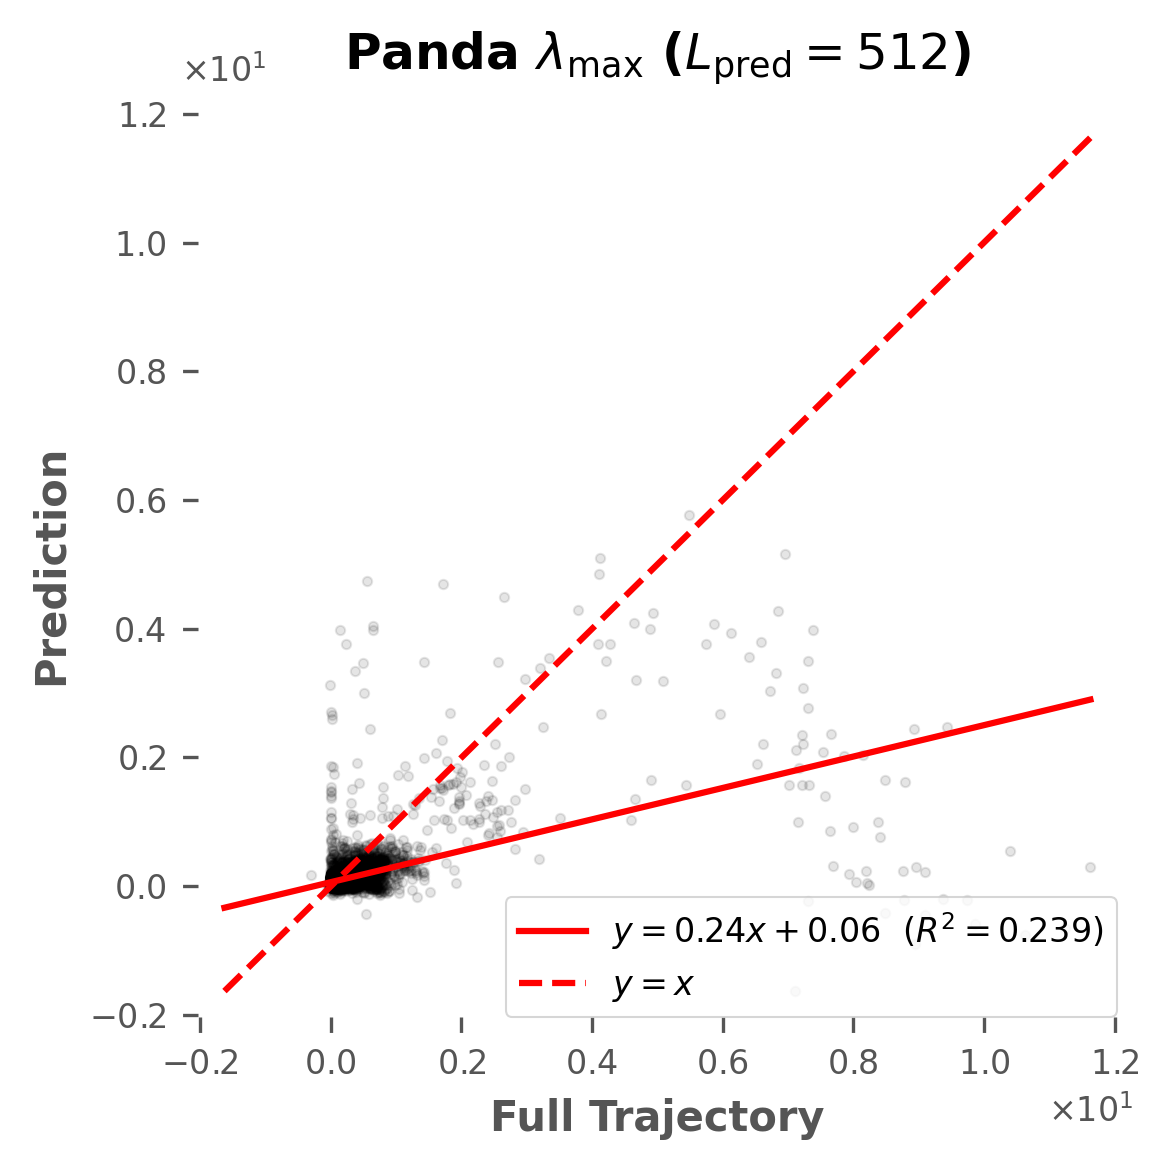

In [26]:
import pandas as pd
from scipy.stats import pearsonr

full_lyaps = [full_traj_lyap_r_dict[sys] for sys in full_traj_lyap_r_dict.keys()]
lyaps = metrics["max_lyap_r_pred"]
results = defaultdict(dict)
for model in lyaps.keys():
    lyaps_for_model = lyaps[model]
    for pred_length in lyaps_for_model.keys():
        if pred_length == "128":  # TODO: remove when we have 128 predictions
            continue
        model_lyaps = lyaps_for_model[pred_length]
        model_lyaps = [model_lyaps[sys] for sys in model_lyaps.keys()]
        assert len(model_lyaps) == len(full_lyaps)

        # measure correlation and wilcoxon signed rank test statistics and pvalues
        result = pearsonr(full_lyaps, model_lyaps)
        results[model][pred_length] = {
            "corr": result.statistic,
            "pval": result.pvalue,
        }


pd.DataFrame(results).T


In [ ]:
# Choose the prediction interval (pred_length) of 512
pred_length = "512"
model_type = "panda"
model_type_title = model_type.replace("_", " ").title()
if model_type == "chronos_zs":
    model_type_title = "Chronos"
elif model_type == "chronos_sft":
    model_type_title = "Chronos SFT"
elif model_type == "panda":
    model_type_title = "Panda"
else:
    raise ValueError(f"Invalid model type: {model_type}")


use_pred_with_context = False
if use_pred_with_context:
    key = "max_lyap_r_predcontext"
    key_label = "Context + Prediction"
else:
    key = "max_lyap_r_pred"
    key_label = "Prediction"

# Get the dictionaries for gtcontext and predcontext at pred_length 512 for model_type
lyap_r_pred_dict = metrics[key][model_type].get(pred_length, {})

# Find the intersection of system names present in both
system_names = set(full_traj_lyap_r_dict.keys()) & set(lyap_r_pred_dict.keys())

# Prepare x and y data for scatter plot
x = [full_traj_lyap_r_dict[sys] for sys in system_names]
y = [lyap_r_pred_dict[sys] for sys in system_names]

# Compute R^2 score, avoiding inf/nan values
if len(x) > 0 and len(y) > 0:
    x_arr = np.asarray(x)
    y_arr = np.asarray(y)
    mask = (
        np.isfinite(x_arr)
        & np.isfinite(y_arr)
        & (np.abs(x_arr) < np.finfo(np.float64).max)
        & (np.abs(y_arr) < np.finfo(np.float64).max)
    )
    if np.sum(mask) > 0:
        r2 = r2_score(x_arr[mask], y_arr[mask])
    else:
        r2 = float("nan")
else:
    r2 = float("nan")

plt.figure(figsize=(4, 4))
plt.scatter(x, y, color="black", s=5, alpha=0.1, label=None)
plt.xlabel("Full Trajectory", fontweight="bold")
plt.ylabel(key_label, fontweight="bold")
plt.title(
    rf"{model_type_title} $\lambda_{{\max}}$ ($L_{{\mathrm{{pred}}}} = {pred_length}$)",
    fontweight="bold",
)

# Prepare handles and labels for legend
handles = []
labels = []

# Plot y=x line in red dashed, but do NOT add to legend yet
y_eq_x_min = min(x + y)
y_eq_x_max = max(x + y)
(h1,) = plt.plot(
    [y_eq_x_min, y_eq_x_max], [y_eq_x_min, y_eq_x_max], "r--", label=r"$y=x$"
)

# Plot line of best fit as solid red line and prepare equation+R2 for legend
eqn_r2_label = None
if len(x) > 1 and len(y) > 1:
    # Fit line: y = m*x + b
    m, b = np.polyfit(x, y, 1)
    x_fit = np.array([y_eq_x_min, y_eq_x_max])
    y_fit = m * x_fit + b
    # Format equation for label (to be shown in legend with R^2)
    if abs(b) < 1e-10:
        eqn_str = rf"$y = {m:.2f}x$"
    else:
        sign = "+" if b >= 0 else "-"
        eqn_str = rf"$y = {m:.2f}x {sign} {abs(b):.2f}$"
    if not (r2 != r2):  # check for nan
        eqn_r2_label = rf"{eqn_str}  $(R^2 = {r2:.3f})$"
    else:
        eqn_r2_label = eqn_str
    (h2,) = plt.plot(
        x_fit, y_fit, color="red", linestyle="-", linewidth=1.5, label=eqn_r2_label
    )
    # Add best fit line first, then y=x line, to put y=x below in legend
    handles.append(h2)
    labels.append(eqn_r2_label)
    handles.append(h1)
    labels.append(r"$y=x$")
else:
    # If no best fit, just add y=x
    handles.append(h1)
    labels.append(r"$y=x$")

# Show legend in lower right, showing both lines and their labels
ax = plt.gca()
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style="sci", axis="both", scilimits=(0, 0))

if len(handles) > 0:
    ax.legend(
        handles=handles, labels=labels, loc="lower right", fontsize=8, frameon=True
    )

plt.tight_layout()
plt.savefig(
    os.path.join(
        "../figures",
        f"max_lyap_r_full_traj_pred_{pred_length}_{model_type}.pdf",
    ),
    bbox_inches="tight",
)

plt.show()